In [561]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Preprocessing and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)



In [562]:
label_df = pd.read_csv("./data_csv/failed_bank-data_2008_2010.csv")
label_df["LABEL"] = 1
label_df = label_df[["CERT","LABEL"]]
label_df = label_df.rename(columns={"CERT" : "cert", "LABEL" : "label"})

In [525]:
len(label_df)

335

In [526]:
label_df = pd.read_csv("./data_csv/failed_bank-data_2008_2010.csv")

In [563]:
"Reload the CSV file after code execution state reset"
financial_files_path = "./data_csv/Financial_*.csv"
all_files = glob.glob(financial_files_path)

In [564]:
df_list = []
for file in all_files:
    temp_df = pd.read_csv(file)
    quarter = file.split("_")[2] + "_" + file.split("_")[3].split(".")[0]
    temp_df["QUARTER"] = quarter
    df_list.append(temp_df)

In [565]:
merged_df = pd.concat(df_list)

In [566]:
nan_percentage = merged_df.isna().mean() * 100

In [570]:
total_nan_percentage = merged_df.isna().sum().sum() / merged_df.size * 100
print(f"Total NaN percentage: {total_nan_percentage:.2f}%")

Total NaN percentage: 8.65%


In [530]:
len(merged_df.columns)

159

In [531]:
# merged_df = merged_df.merge(label_df, on = "CERT", how = "left")

In [532]:
# merged_df = merged_df[merged_df['IDT1RWAJR'] < 100] # added after first round

In [533]:
merged_df["CERT"].nunique()

10030

In [534]:
merged_df["TFRA"].describe()

count    1.235720e+05
mean     1.982341e+06
std      6.259706e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.589705e+09
Name: TFRA, dtype: float64

In [535]:
# Define useful features for CAMELS-based feature engineering
camel_core_features = [
    # Capital Adequacy
    'EQV', 'EQTOT', 'IDT1RWAJR', 'RBCRWAJ',

    # Asset Quality
    'LNATRESR', 'NTLNLSR', 'NCLNLSR', 'LNLSDEPR', 'LNLSNET',
    'ORE', 'P3ASSET', 'NCRER', 'NCRERESR', 'NTRECOSR','EQCDIVNTINC',

    # Management
    'EINTEXP', 'INTINC', 'NUMEMP',

    # Earnings
    'ROA', 'ROAPTX', 'ROE', 'PTAXNETINC', 'NETINC',
    'NOIJ', 'NONII', 'NIM',

    # Liquidity
    'DEP', 'COREDEP', 'DEPINS', 'DEPUNINS', 'DEPNIDOM',

    # Sensitivity to Market Risk
    'IGLSEC', 'ASDRRES',

    # Total Assets
    'NAASSET'
]

# Optional metadata for grouping, merging, filtering
metadata_fields = [
    'CERT', 'NAMEFULL','CITY', 'QUARTER'
]

# Labeling or time metadata
labeling_fields = [
    'INSDATE', 'ESTYMD'
]

# Final full set to keep
columns_to_keep = camel_core_features + metadata_fields + labeling_fields

In [536]:
selected_merged_df = merged_df[columns_to_keep]

In [537]:
selected_merged_df.describe()

EQV         EQTOT      IDT1RWAJR        RBCRWAJ  \
count  123572.000000  1.233010e+05  123572.000000  123572.000000   
mean       12.456808  1.306563e+05      20.799747      25.391862   
std        11.049177  1.991125e+06     118.616902     156.091798   
min       -16.065911 -1.311200e+04     -18.955043     -18.955043   
25%         8.411170  6.322000e+03      10.987732      12.212456   
50%         9.888535  1.249400e+04      13.736420      14.995298   
75%        12.431444  2.808400e+04      18.857978      20.266446   
max       100.049505  1.798135e+08   22798.245614   26200.000000   

            LNATRESR        NTLNLSR        NCLNLSR      LNLSDEPR  \
count  123572.000000  123572.000000  123572.000000  1.235720e+05   
mean        1.401141       0.254550       1.143081  1.010582e+03   
std         1.341104       2.151341       2.412998  9.008876e+04   
min         0.000000    -440.568696       0.000000 -1.230315e+01   
25%         0.964798       0.000000       0.117672  6.440095e+01   
50%         1.224777       0.047241       0.508511  7.996354e+01   
75%         1.571552       0.223267       1.302603  9.289045e+01   
max       100.000000      98.372377     100.000000  2.119370e+07   

            LNLSNET           ORE  ...       COREDEP        DEPINS  \
count  1.235720e+05  1.233010e+05  ...  1.235360e+05  1.235720e+05   
mean   7.379641e+05  1.430146e+03  ...  5.805015e+05  4.645070e+05   
std    1.050111e+07  3.322018e+04  ...  8.795727e+06  6.220349e+06   
min   -1.250000e+02 -1.939900e+04  ... -3.478500e+04  0.000000e+00   
25%    3.219150e+04  0.000000e+00  ...  3.771500e+04  3.629450e+04   
50%    7.546400e+04  0.000000e+00  ...  7.872300e+04  7.459200e+04   
75%    1.847878e+05  2.710000e+02  ...  1.820802e+05  1.697590e+05   
max    7.137270e+08  5.794000e+06  ...  7.846693e+08  7.049560e+08   

           DEPUNINS      DEPNIDOM        IGLSEC       ASDRRES       NAASSET  \
count  1.235710e+05  1.233010e+05  1.233010e+05  1.115980e+05  1.235720e+05   
mean   2.470188e+05  1.391849e+05  4.471938e+02  6.655085e+03  7.083879e+03   
std    4.171823e+06  2.894917e+06  2.100930e+04  2.701424e+05  2.081819e+05   
min   -2.795920e+05  0.000000e+00 -1.463000e+06  0.000000e+00  0.000000e+00   
25%    5.687000e+03  5.293000e+03  0.000000e+00  0.000000e+00  9.000000e+00   
50%    1.735300e+04  1.261600e+04  0.000000e+00  0.000000e+00  2.510000e+02   
75%    4.937650e+04  3.086400e+04  3.000000e+00  0.000000e+00  1.088000e+03   
max    3.379600e+08  2.948670e+08  2.975000e+06  2.698500e+07  3.013552e+07   

                CERT       INSDATE        ESTYMD  
count  123572.000000  1.235720e+05  1.235720e+05  
mean    21393.905537  2.046787e+07  1.938401e+07  
std     16032.855228  8.261582e+06  4.346905e+05  
min         9.000000  1.933120e+07  1.784010e+07  
25%      9433.000000  1.934010e+07  1.904020e+07  
50%     17880.000000  1.954050e+07  1.929051e+07  
75%     30337.000000  1.989081e+07  1.984010e+07  
max     91385.000000  9.999123e+07  2.010122e+07  

[8 rows x 37 columns]

In [538]:
selected_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123572 entries, 0 to 7747
Data columns (total 40 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   EQV          123572 non-null  float64
 1   EQTOT        123301 non-null  float64
 2   IDT1RWAJR    123572 non-null  float64
 3   RBCRWAJ      123572 non-null  float64
 4   LNATRESR     123572 non-null  float64
 5   NTLNLSR      123572 non-null  float64
 6   NCLNLSR      123572 non-null  float64
 7   LNLSDEPR     123572 non-null  float64
 8   LNLSNET      123572 non-null  int64  
 9   ORE          123301 non-null  float64
 10  P3ASSET      123572 non-null  int64  
 11  NCRER        123572 non-null  float64
 12  NCRERESR     123572 non-null  float64
 13  NTRECOSR     123572 non-null  float64
 14  EQCDIVNTINC  123572 non-null  float64
 15  EINTEXP      123301 non-null  float64
 16  INTINC       123301 non-null  float64
 17  NUMEMP       123301 non-null  float64
 18  ROA          123572 non-null  f

In [539]:
# non_null_counts = selected_merged_df.notnull().sum()

In [540]:
# selected_merged_df = selected_merged_df.dropna()

In [541]:
# Set the visual style
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Plot distributions
def plot_feature_distributions(df, features, bins=100):
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        if feature in df.columns:
            sns.histplot(df[feature].dropna(), kde=True, bins=bins, ax=axes[i])
            axes[i].set_title(feature)
        else:
            axes[i].axis("off")

    # # Turn off any unused subplots
    # for j in range(i + 1, len(axes)):
    #     axes[j].axis("off")

    plt.tight_layout()
    plt.show()



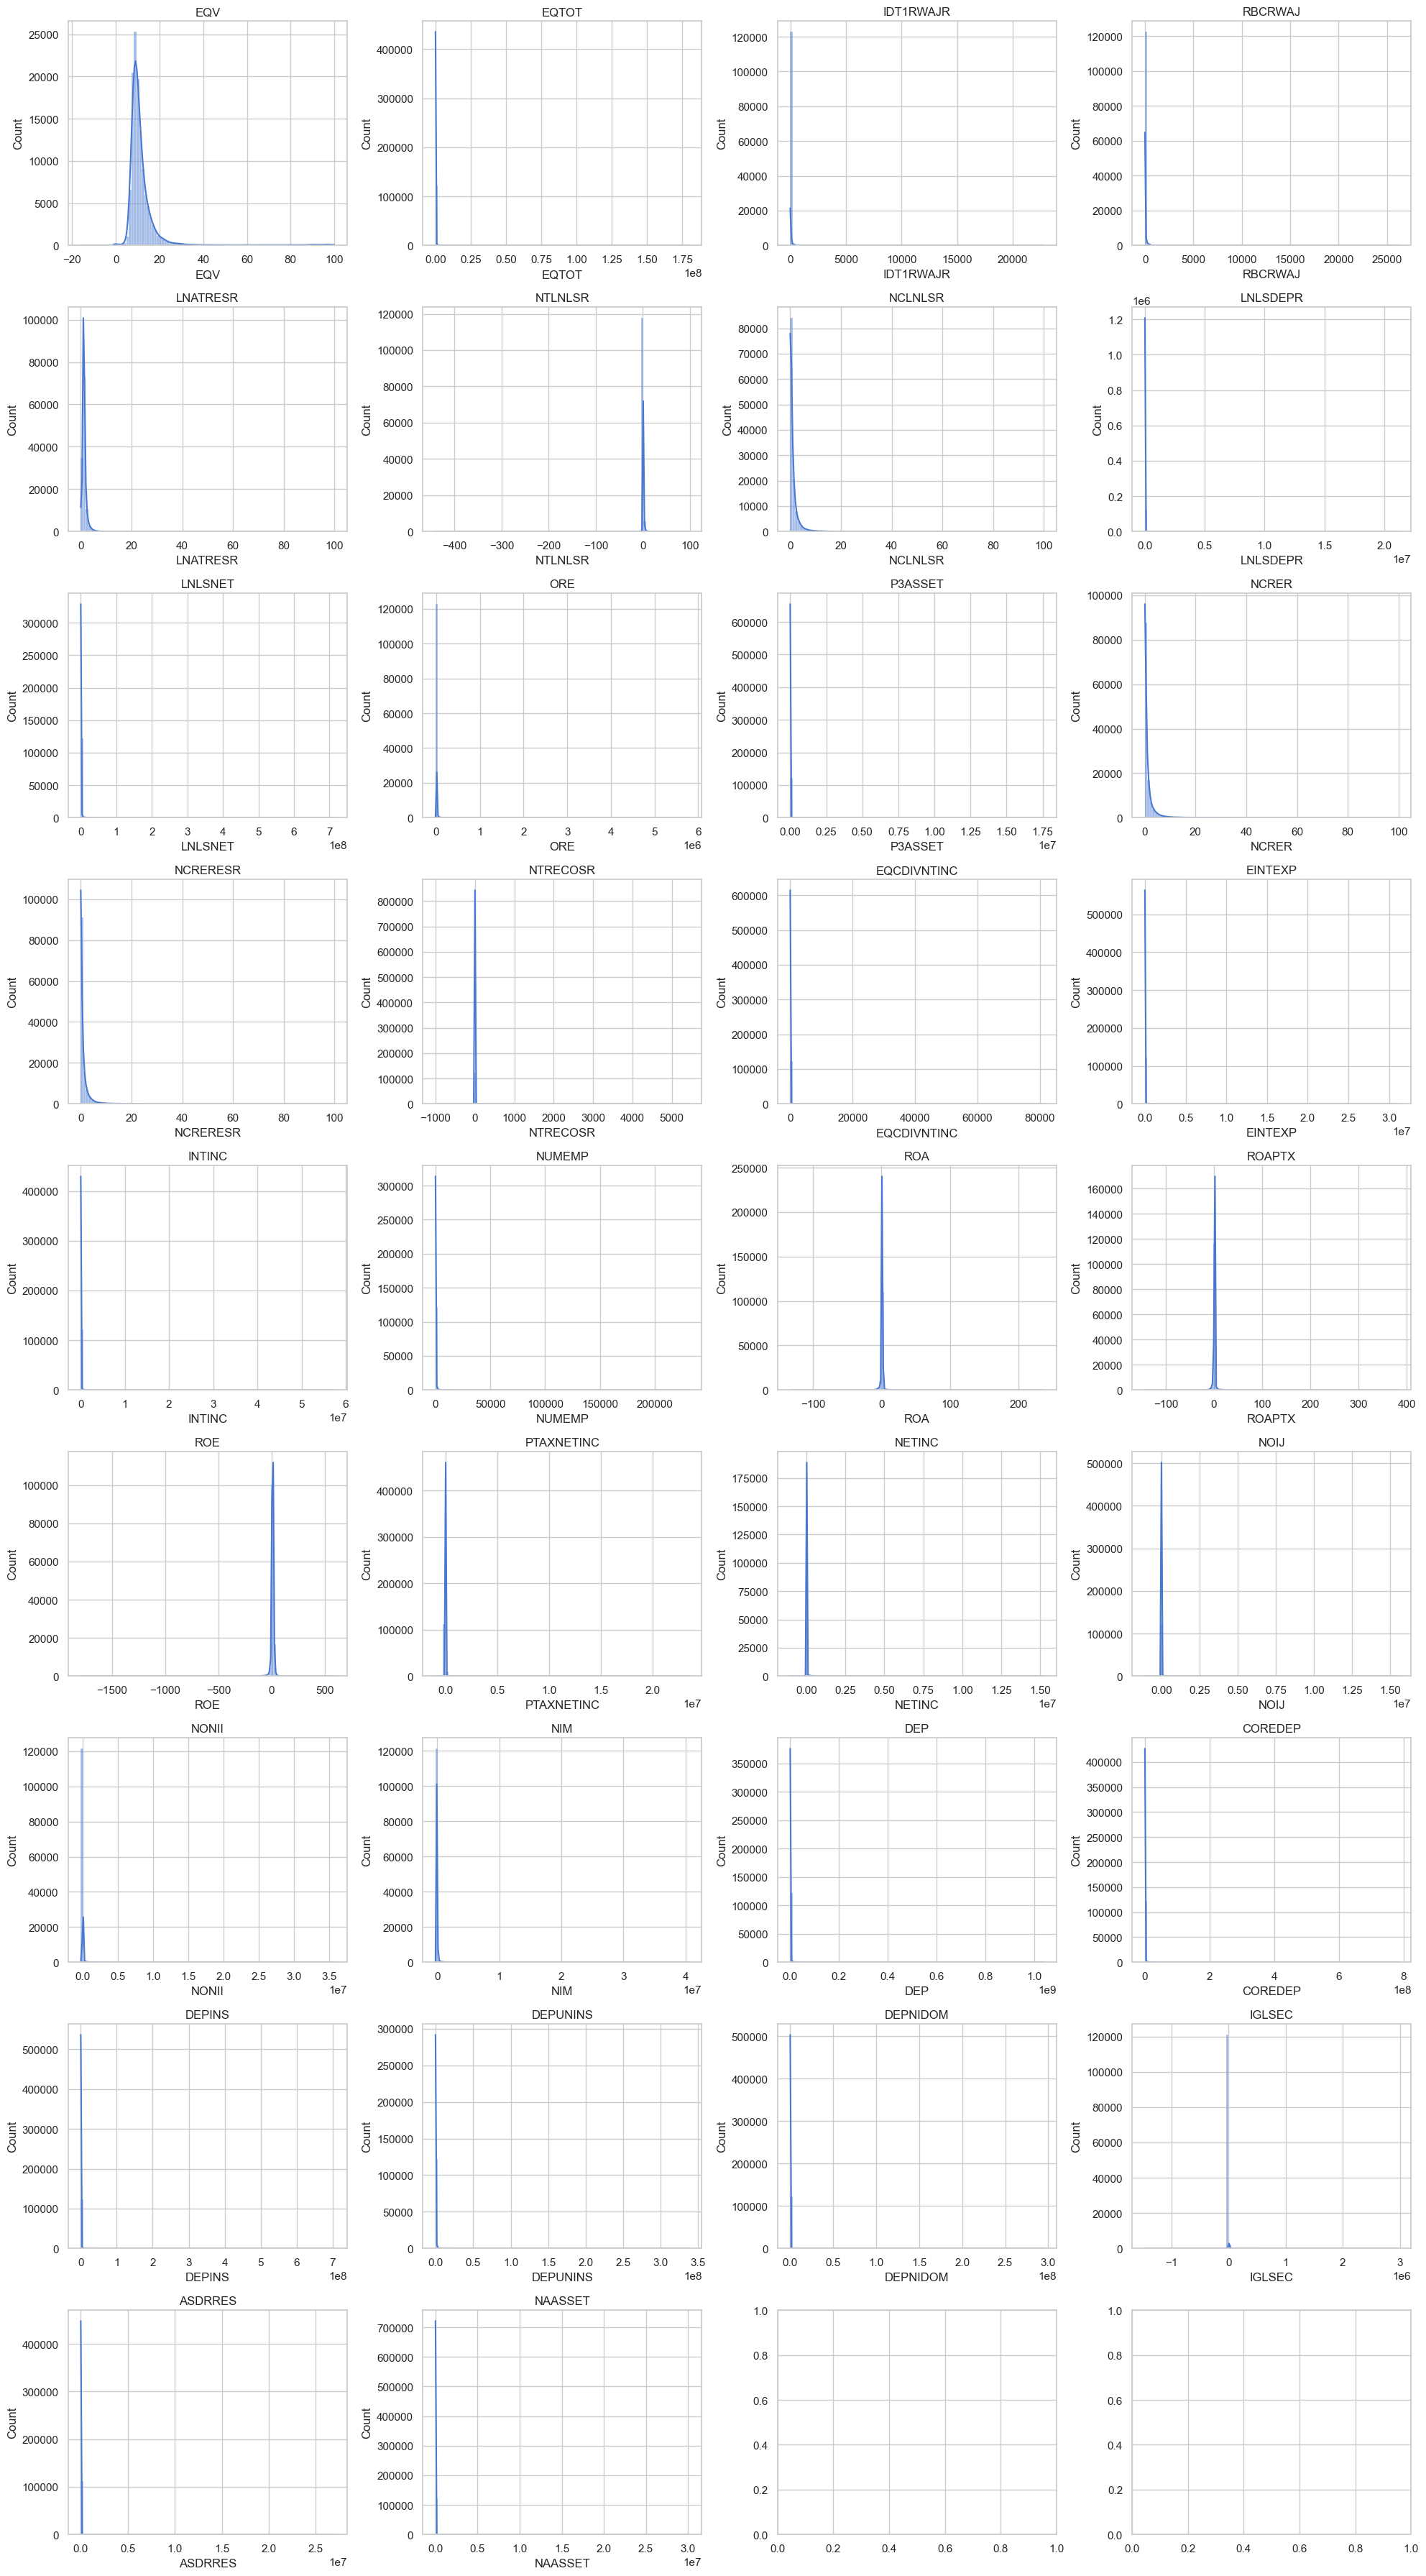

In [542]:
# Run the plot function
plot_feature_distributions(selected_merged_df, camel_core_features)

In [543]:
camels_ratios_df = pd.DataFrame({
    "cert": selected_merged_df["CERT"],
    "bank_name": selected_merged_df["NAMEFULL"],
    "quarter": selected_merged_df["QUARTER"],

    # Capital Adequacy (C)
    "equity_to_assets": selected_merged_df["EQV"] / selected_merged_df["NAASSET"],
    "tier1_rwa_ratio": selected_merged_df["IDT1RWAJR"],
    "total_equity_ratio": selected_merged_df["EQTOT"] / selected_merged_df["NAASSET"],
    "dividends_to_equity": selected_merged_df["EQCDIVNTINC"] / selected_merged_df["EQV"],

    # Asset Quality (A)
    "loan_loss_reserve_to_loans": selected_merged_df["LNATRESR"] / selected_merged_df["NTLNLSR"],
    "noncurrent_loans_to_loans": selected_merged_df["NCLNLSR"] / selected_merged_df["NTLNLSR"],
    "ore_to_assets": selected_merged_df["ORE"] / selected_merged_df["NAASSET"],
    "assets_past_due_30_89_to_assets": selected_merged_df["P3ASSET"] / selected_merged_df["NAASSET"],
    "noncurrent_real_estate_to_assets": selected_merged_df["NCRER"] / selected_merged_df["NAASSET"],
    "noncurrent_re_to_loans": selected_merged_df["NCRERESR"] / selected_merged_df["NTLNLSR"],

    # Management (M)
    "efficiency_ratio_proxy": selected_merged_df["EINTEXP"] / selected_merged_df["INTINC"],
    "noninterest_income_to_assets": selected_merged_df["NONII"] / selected_merged_df["NAASSET"],
    "operating_income_to_assets": selected_merged_df["NOIJ"] / selected_merged_df["NAASSET"],
    "assets_per_employee": selected_merged_df["NAASSET"] / selected_merged_df["NUMEMP"],

    # Earnings (E)
    "return_on_assets": selected_merged_df["ROA"],
    "pretax_return_on_assets": selected_merged_df["ROAPTX"],
    "return_on_equity": selected_merged_df["ROE"],
    "net_income_to_assets": selected_merged_df["NETINC"] / selected_merged_df["NAASSET"],
    "pretax_income_to_assets": selected_merged_df["PTAXNETINC"] / selected_merged_df["NAASSET"],

    # Liquidity (L)
    "net_loans_to_total_deposits": selected_merged_df["LNLSNET"] / selected_merged_df["DEP"],
    "uninsured_deposits_to_total_deposits": selected_merged_df["DEPUNINS"] / selected_merged_df["DEP"],
    "insured_deposits_to_total_deposits": selected_merged_df["DEPINS"] / selected_merged_df["DEP"],

    # Sensitivity (S) — intentionally excluded due to poor data
    # "securities_to_assets" and "asset_sensitivity_proxy" excluded
})

In [544]:
camels_ratios_df.columns

Index(['cert', 'bank_name', 'quarter', 'equity_to_assets', 'tier1_rwa_ratio',
       'total_equity_ratio', 'dividends_to_equity',
       'loan_loss_reserve_to_loans', 'noncurrent_loans_to_loans',
       'ore_to_assets', 'assets_past_due_30_89_to_assets',
       'noncurrent_real_estate_to_assets', 'noncurrent_re_to_loans',
       'efficiency_ratio_proxy', 'noninterest_income_to_assets',
       'operating_income_to_assets', 'assets_per_employee', 'return_on_assets',
       'pretax_return_on_assets', 'return_on_equity', 'net_income_to_assets',
       'pretax_income_to_assets', 'net_loans_to_total_deposits',
       'uninsured_deposits_to_total_deposits',
       'insured_deposits_to_total_deposits'],
      dtype='object')

In [545]:
# # Run the plot function
# plot_feature_distributions(camels_ratios_df, camels_ratios_df.columns[3:])

In [546]:
camels_ratios_df = camels_ratios_df.replace([np.inf, -np.inf], np.nan)

In [547]:
joined_df = pd.merge(camels_ratios_df,label_df, on = "cert", how = "left")
joined_df["label"] = joined_df["label"].fillna(0).astype(int) 

KeyError: 'cert'

In [ ]:
label_1_df = joined_df[joined_df['label'] == 1]

In [ ]:
label_0_df = joined_df[joined_df['label'] == 0].dropna()

In [ ]:
#Remove outliers from label=0 using IQR filtering 
def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
    return cleaned_df

In [ ]:
ratio_columns = label_0_df.select_dtypes(include=[np.number]).columns.drop(['label', 'cert'])

In [ ]:
label_0_df_cleaned = remove_outliers_iqr(label_0_df, ratio_columns)

In [483]:
len(label_0_df_cleaned)

18111

In [548]:
final_df = pd.concat([label_0_df_cleaned, label_1_df], ignore_index=True)

In [549]:
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [486]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21930 entries, 0 to 21929
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cert                                  21930 non-null  int64  
 1   bank_name                             21930 non-null  object 
 2   quarter                               21930 non-null  object 
 3   equity_to_assets                      21067 non-null  float64
 4   tier1_rwa_ratio                       21930 non-null  float64
 5   total_equity_ratio                    21067 non-null  float64
 6   dividends_to_equity                   21930 non-null  float64
 7   loan_loss_reserve_to_loans            21256 non-null  float64
 8   noncurrent_loans_to_loans             21256 non-null  float64
 9   ore_to_assets                         21067 non-null  float64
 10  assets_past_due_30_89_to_assets       21067 non-null  float64
 11  noncurrent_real

In [487]:
not_null = final_df.notnull().sum()

In [488]:
not_null

cert                                    21930
bank_name                               21930
quarter                                 21930
equity_to_assets                        21067
tier1_rwa_ratio                         21930
total_equity_ratio                      21067
dividends_to_equity                     21930
loan_loss_reserve_to_loans              21256
noncurrent_loans_to_loans               21256
ore_to_assets                           21067
assets_past_due_30_89_to_assets         21067
noncurrent_real_estate_to_assets        21067
noncurrent_re_to_loans                  21256
efficiency_ratio_proxy                  21928
noninterest_income_to_assets            21067
operating_income_to_assets              21067
assets_per_employee                     21915
return_on_assets                        21930
pretax_return_on_assets                 21930
return_on_equity                        21930
net_income_to_assets                    21067
pretax_income_to_assets           

In [550]:
def clean_df(df):
    df = df.copy()

    # Clip extreme outliers (winsorization)
    clip_limits = {
    "equity_to_assets": (-1, 1),
    "tier1_rwa_ratio": (0, 100),  # 100% Tier 1 cap
    "total_equity_ratio": (0, 1000),
    "dividends_to_equity": (0, 20),
    "loan_loss_reserve_to_loans": (0, 100),
    "noncurrent_loans_to_loans": (0, 100),
    "ore_to_assets": (0, 1),
    "assets_past_due_30_89_to_assets": (0, 1),
    "noncurrent_real_estate_to_assets": (0, 1),
    "efficiency_ratio_proxy": (0, 2),
    "noninterest_income_to_assets": (-1, 1),
    "operating_income_to_assets": (-1, 20),  # beyond that looks like noise
    "assets_per_employee": (0, np.nanpercentile(camels_ratios_df["assets_per_employee"], 99)),
    "return_on_assets": (-1, 5),
    "pretax_return_on_assets": (-1, 5),
    "return_on_equity": (-50, 50),  # allow a broader range
    "net_income_to_assets": (-10, 10),
    "pretax_income_to_assets": (-10, 10),
    "net_loans_to_total_deposits": (0, 2),
    "uninsured_deposits_to_total_deposits": (0, 2),
    "insured_deposits_to_total_deposits": (0, 1.5),
    }

    for col, (low, high) in clip_limits.items():
        df[col] = df[col].clip(lower=low, upper=high)

    # Optional: drop rows with too many NaNs
    df = df.dropna(thresh=int(df.shape[1] * 0.8))  # keep rows with at least 80% non-NaN

    return df

In [254]:
# # Run the plot function
# plot_feature_distributions(camels_ratios_df, camels_ratios_df.columns[3:])

In [551]:
cleaned_final_df = clean_df(final_df)

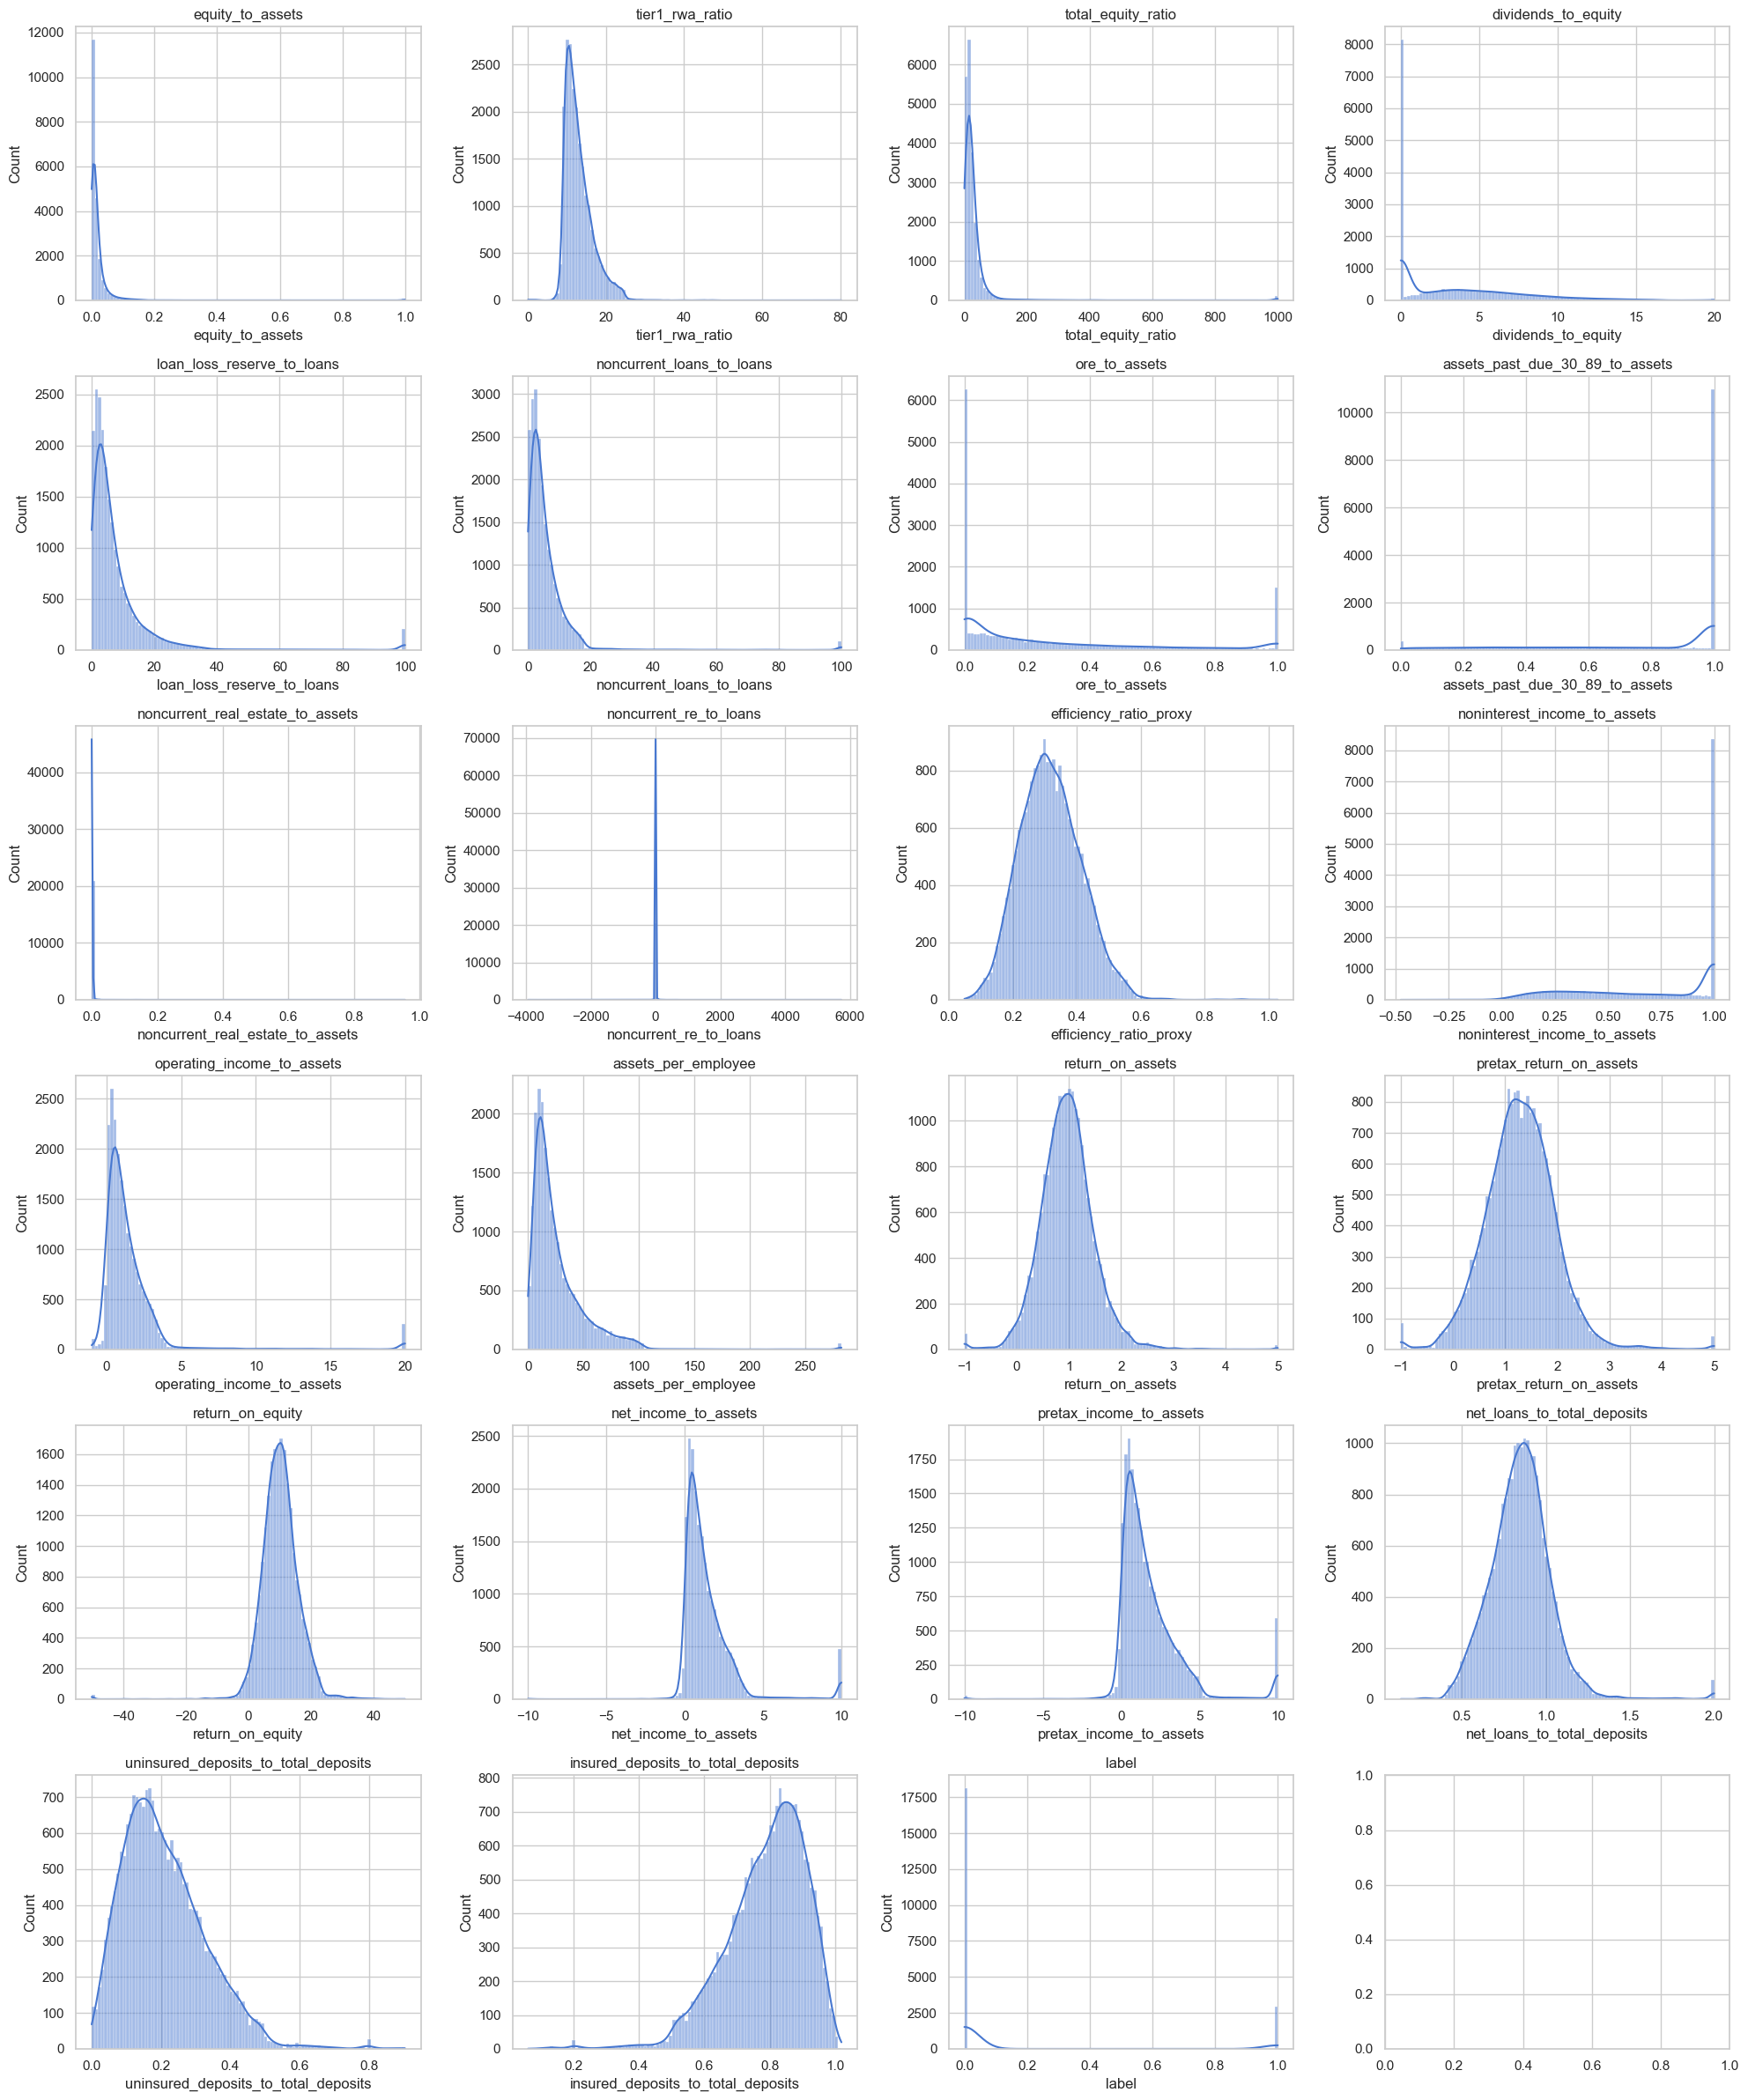

In [491]:
# Run the plot function
plot_feature_distributions(cleaned_final_df, cleaned_final_df.columns[3:])

In [492]:
print(cleaned_final_df.describe())

               cert  equity_to_assets  tier1_rwa_ratio  total_equity_ratio  \
count  21067.000000      21067.000000     21067.000000        21067.000000   
mean   19202.609484          0.020635        13.043794           32.535287   
std    13979.417920          0.068534         3.773449           88.904950   
min        9.000000         -0.000747         0.000000            0.000000   
25%     8552.000000          0.003131        10.423738            9.510062   
50%    16470.000000          0.007748        12.132811           16.856448   
75%    28926.000000          0.017879        14.720688           29.001983   
max    91280.000000          1.000000        80.328952         1000.000000   

       dividends_to_equity  loan_loss_reserve_to_loans  \
count         21067.000000                20825.000000   
mean              3.516888                    8.065251   
std               3.963235                   12.754084   
min               0.000000                    0.000000   
25%    

In [552]:
def parse_quarter_to_date(quarter_str:str) -> pd.Timestamp:
    year,qtr = quarter_str.split("_")
    quarter_month_map = {"Q1": "01", "Q2": "04", "Q3": "07", "Q4": "10"}
    month = quarter_month_map[qtr]
    return pd.to_datetime(f"{year}-{month}-01")

In [553]:
cleaned_final_df["date"] = cleaned_final_df["quarter"].apply(parse_quarter_to_date)

In [554]:
def engineer_lag_features_optimized(df: pd.DataFrame, features: list, max_lag: int = 8,
                                    bank_id_col: str = "cert") -> pd.DataFrame:
    """
    Add lag features for specified CAMELS variables.
    
    """
    df = df.copy()
    
    
    df = df.sort_values(by=[bank_id_col, "date"])

    lag_dfs = [df]

    # Generate lag features for each specified variable
    for lag in range(1, max_lag + 1):
        lagged = (
            df.groupby(bank_id_col)[features]
              .shift(lag)
              .add_suffix(f"_lag{lag}")
        )
        lag_dfs.append(lagged)

    # Concatenate all in one go for performance
    df_with_lags = pd.concat(lag_dfs, axis=1)

    return df_with_lags

In [261]:
# cleaned_camels_ratios_df.columns[3:-1]

In [555]:
engineered_df = engineer_lag_features_optimized(cleaned_final_df,features = camels_ratios_df.columns[3:-1])

In [556]:
engineered_df = engineered_df[engineered_df["quarter"] == '2006_Q4']

In [560]:
engineered_df

cert                               bank_name  quarter  \
4504      46               MERCHANTS BANK OF ALABAMA  2006_Q4   
8086      47                  TRADERS & FARMERS BANK  2006_Q4   
19330     58                             UNITED BANK  2006_Q4   
20836     70  PEOPLES EXCHANGE BANK OF MONROE COUNTY  2006_Q4   
8974      90         COMMERCIAL BANK & TRUST COMPANY  2006_Q4   
...      ...                                     ...      ...   
2827   90179                   CHICOPEE SAVINGS BANK  2006_Q4   
5388   90183                  MIDDLESEX SAVINGS BANK  2006_Q4   
5515   90185                             DANVERSBANK  2006_Q4   
8869   90303                SOUTH SHORE SAVINGS BANK  2006_Q4   
19479  90311                  BAY STATE SAVINGS BANK  2006_Q4   

       equity_to_assets  tier1_rwa_ratio  total_equity_ratio  \
4504           0.005842        10.987000           11.935128   
8086           0.009412        16.030619           33.603806   
19330          0.005970        13.710667           25.464968   
20836          0.026642        16.120596           15.890792   
8974           0.004233        14.306809            7.185687   
...                 ...              ...                 ...   
2827           0.009277        18.330676           41.201636   
5388           0.001116        16.649330           37.154914   
5515           0.001339         9.873969           16.306022   
8869           0.003824        13.549261           34.998806   
19479          0.007212        12.706830           21.033844   

       dividends_to_equity  loan_loss_reserve_to_loans  \
4504              0.000000                   12.900210   
8086              3.385485                   10.529637   
19330             3.917641                    2.769595   
20836             1.282028                    0.000000   
8974              7.800174                    2.043757   
...                    ...                         ...   
2827              0.000000                   19.409142   
5388              0.000000                   24.785833   
5515              5.112685                   14.964742   
8869              0.000000                   30.028069   
19479             0.000000                   10.462342   

       noncurrent_loans_to_loans  ore_to_assets  ...  \
4504                    8.117422       0.000000  ...   
8086                    5.727639       0.580450  ...   
19330                   1.451922       0.395541  ...   
20836                   0.000000       0.040685  ...   
8974                    3.728864       0.483075  ...   
...                          ...            ...  ...   
2827                   11.419891       0.000000  ...   
5388                   11.898004       0.000000  ...   
5515                    7.974986       0.000000  ...   
8869                   13.955691       0.000000  ...   
19479                   7.628535       0.000000  ...   

       noninterest_income_to_assets_lag8  operating_income_to_assets_lag8  \
4504                                 NaN                              NaN   
8086                            0.559466                         1.289097   
19330                           1.000000                         2.169161   
20836                                NaN                              NaN   
8974                                 NaN                              NaN   
...                                  ...                              ...   
2827                                 NaN                              NaN   
5388                                 NaN                              NaN   
5515                                 NaN                              NaN   
8869                                 NaN                              NaN   
19479                           0.599084                         0.735785   

       assets_per_employee_lag8  return_on_assets_lag8  \
4504                        NaN                    NaN   
8086                  23.607692               1

In [557]:
len(engineered_df)

1247

In [499]:
with pd.option_context('display.max_rows', None):
    print(engineered_df.isnull().sum())

cert                                           0
bank_name                                      0
quarter                                        0
equity_to_assets                               0
tier1_rwa_ratio                                0
total_equity_ratio                             0
dividends_to_equity                            0
loan_loss_reserve_to_loans                    11
noncurrent_loans_to_loans                     11
ore_to_assets                                  0
assets_past_due_30_89_to_assets                0
noncurrent_real_estate_to_assets               0
noncurrent_re_to_loans                        11
efficiency_ratio_proxy                         0
noninterest_income_to_assets                   0
operating_income_to_assets                     0
assets_per_employee                            0
return_on_assets                               0
pretax_return_on_assets                        0
return_on_equity                               0
net_income_to_assets

In [266]:
# def impute_selected_with_mean(df, columns):
#     df = df.copy()
#     for col in columns:
#         mean_value = df[col].mean()
#         df[col] = df[col].fillna(mean_value)
#     return df

# # Columns you want to impute with mean
# cols_to_impute_with_mean = ["efficiency_ratio_proxy","return_on_assets", "return_on_equity",]

# # Apply the function
# engineered_df = impute_selected_with_mean(engineered_df, cols_to_impute_with_mean)

In [500]:
def impute_selected_with_mean(df, columns):
    df = df.copy()
    for col in columns:
        mean_value = df[col].median()
        df[col] = df[col].fillna(mean_value)
    return df

cols_to_impute_with_median = engineered_df.columns[3:]

# Apply the functio
engineered_df = impute_selected_with_mean(engineered_df, cols_to_impute_with_median)

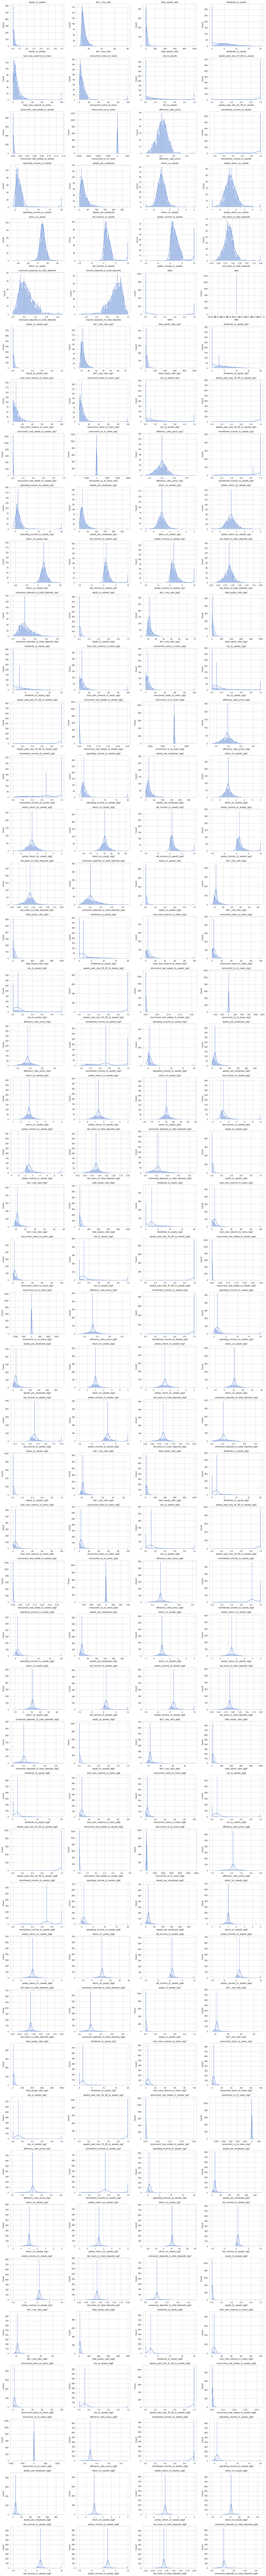

In [501]:
# Run the plot function
plot_feature_distributions(engineered_df, engineered_df.columns[3:])

In [502]:
engineered_df.columns

Index(['cert', 'bank_name', 'quarter', 'equity_to_assets', 'tier1_rwa_ratio',
       'total_equity_ratio', 'dividends_to_equity',
       'loan_loss_reserve_to_loans', 'noncurrent_loans_to_loans',
       'ore_to_assets',
       ...
       'noninterest_income_to_assets_lag8', 'operating_income_to_assets_lag8',
       'assets_per_employee_lag8', 'return_on_assets_lag8',
       'pretax_return_on_assets_lag8', 'return_on_equity_lag8',
       'net_income_to_assets_lag8', 'pretax_income_to_assets_lag8',
       'net_loans_to_total_deposits_lag8',
       'uninsured_deposits_to_total_deposits_lag8'],
      dtype='object', length=195)

In [503]:
# merged_df = engineered_df.merge(label_df, on = "cert", how = "left")
# merged_df["label"] = merged_df["label"].fillna(0).astype(int) 

In [ ]:
# X = engineered_df.drop(columns=['cert', 'bank_name', 'quarter', 'label'], errors='ignore')
# y = engineered_df['label']

In [435]:
print(engineered_df)

        cert                               bank_name  quarter  \
4504      46               MERCHANTS BANK OF ALABAMA  2006_Q4   
8086      47                  TRADERS & FARMERS BANK  2006_Q4   
19330     58                             UNITED BANK  2006_Q4   
20836     70  PEOPLES EXCHANGE BANK OF MONROE COUNTY  2006_Q4   
8974      90         COMMERCIAL BANK & TRUST COMPANY  2006_Q4   
...      ...                                     ...      ...   
2827   90179                   CHICOPEE SAVINGS BANK  2006_Q4   
5388   90183                  MIDDLESEX SAVINGS BANK  2006_Q4   
5515   90185                             DANVERSBANK  2006_Q4   
8869   90303                SOUTH SHORE SAVINGS BANK  2006_Q4   
19479  90311                  BAY STATE SAVINGS BANK  2006_Q4   

       equity_to_assets  tier1_rwa_ratio  total_equity_ratio  \
4504           0.005842        10.987000           11.935128   
8086           0.009412        16.030619           33.603806   
19330          0.005970    

In [504]:
X = engineered_df.drop(columns=['cert', 'bank_name', 'quarter', 'date', 'label'], errors='ignore')
y = engineered_df['label']

In [505]:
len(engineered_df)
len(engineered_df[engineered_df['label']== 1])

261

In [506]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [507]:
scaler = StandardScaler()
# Re-standardize for Logistic Regression
X_train_scaled = scaler.fit_transform(X_train.fillna(0))
X_test_scaled = scaler.transform(X_test.fillna(0))

In [508]:
# Ensure target is integer type
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Define models
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(
    n_estimators=100,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

# Train models
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Collect results
results_cleaned = {
    'Logistic Regression': {
        'ROC AUC': roc_auc_score(y_test, lr_probs),
        'Confusion Matrix': confusion_matrix(y_test, lr_preds),
        'Classification Report': classification_report(y_test, lr_preds, output_dict=True)
    },
    'Random Forest': {
        'ROC AUC': roc_auc_score(y_test, rf_probs),
        'Confusion Matrix': confusion_matrix(y_test, rf_preds),
        'Classification Report': classification_report(y_test, rf_preds, output_dict=True)
    },
    'XGBoost': {
        'ROC AUC': roc_auc_score(y_test, xgb_probs),
        'Confusion Matrix': confusion_matrix(y_test, xgb_preds),
        'Classification Report': classification_report(y_test, xgb_preds, output_dict=True)
    }
}

In [509]:
results_cleaned

{'Logistic Regression': {'ROC AUC': np.float64(0.9265302598635932),
  'Confusion Matrix': array([[283,  14],
         [ 19,  59]]),
  'Classification Report': {'0': {'precision': 0.9370860927152318,
    'recall': 0.9528619528619529,
    'f1-score': 0.9449081803005008,
    'support': 297.0},
   '1': {'precision': 0.8082191780821918,
    'recall': 0.7564102564102564,
    'f1-score': 0.7814569536423841,
    'support': 78.0},
   'accuracy': 0.912,
   'macro avg': {'precision': 0.8726526353987119,
    'recall': 0.8546361046361046,
    'f1-score': 0.8631825669714425,
    'support': 375.0},
   'weighted avg': {'precision': 0.9102817744715594,
    'recall': 0.912,
    'f1-score': 0.9109103251556125,
    'support': 375.0}}},
 'Random Forest': {'ROC AUC': np.float64(0.991625658292325),
  'Confusion Matrix': array([[297,   0],
         [ 20,  58]]),
  'Classification Report': {'0': {'precision': 0.9369085173501577,
    'recall': 1.0,
    'f1-score': 0.9674267100977199,
    'support': 297.0},
   '

FEATURE IMPORTANCE

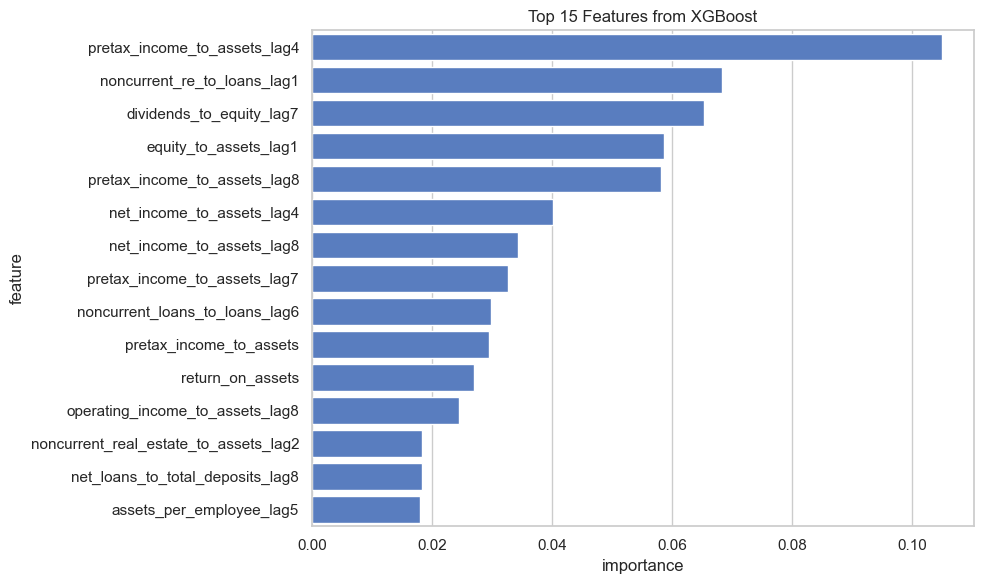

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = xgb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Features from XGBoost')
plt.tight_layout()
plt.show()

In [451]:
importance_df.head(15)

feature  importance
103           pretax_income_to_assets_lag4    0.105027
31             noncurrent_re_to_loans_lag1    0.068279
151               dividends_to_equity_lag7    0.065274
22                   equity_to_assets_lag1    0.058657
187           pretax_income_to_assets_lag8    0.058118
102              net_income_to_assets_lag4    0.040143
186              net_income_to_assets_lag8    0.034224
166           pretax_income_to_assets_lag7    0.032580
132         noncurrent_loans_to_loans_lag6    0.029819
18                 pretax_income_to_assets    0.029518
14                        return_on_assets    0.026952
181        operating_income_to_assets_lag8    0.024450
51   noncurrent_real_estate_to_assets_lag2    0.018286
188       net_loans_to_total_deposits_lag8    0.018272
119               assets_per_employee_lag5    0.017891

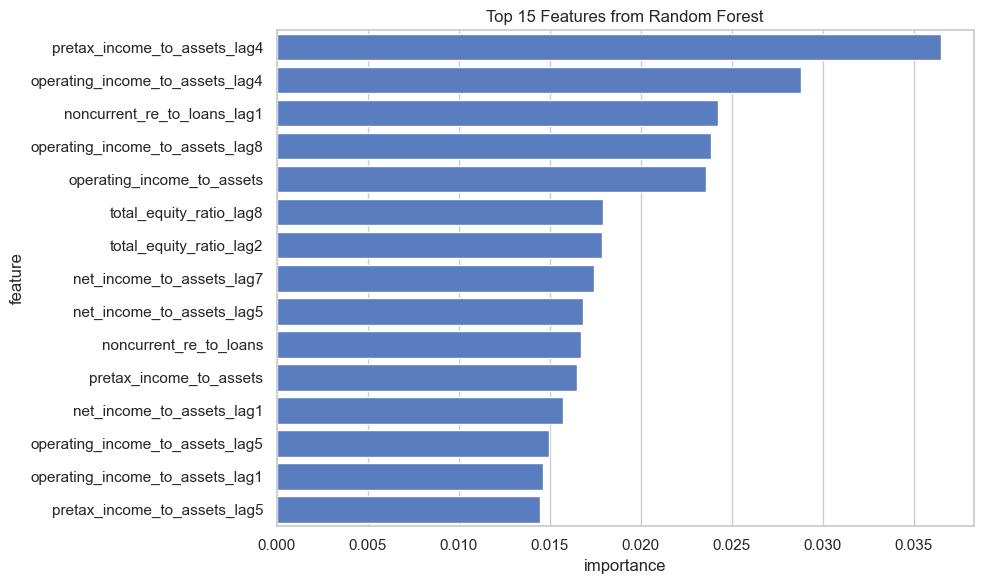

In [446]:
importances_rf = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({
    'feature': features,
    'importance': importances_rf
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf.head(15), x='importance', y='feature')
plt.title('Top 15 Features from Random Forest')
plt.tight_layout()
plt.show()

In [448]:
importance_df_rf.head(15)

feature  importance
103     pretax_income_to_assets_lag4    0.036496
97   operating_income_to_assets_lag4    0.028816
31       noncurrent_re_to_loans_lag1    0.024268
181  operating_income_to_assets_lag8    0.023846
12        operating_income_to_assets    0.023583
171          total_equity_ratio_lag8    0.017937
45           total_equity_ratio_lag2    0.017874
165        net_income_to_assets_lag7    0.017426
123        net_income_to_assets_lag5    0.016841
9             noncurrent_re_to_loans    0.016736
18           pretax_income_to_assets    0.016501
39         net_income_to_assets_lag1    0.015717
118  operating_income_to_assets_lag5    0.014963
34   operating_income_to_assets_lag1    0.014630
124     pretax_income_to_assets_lag5    0.014450

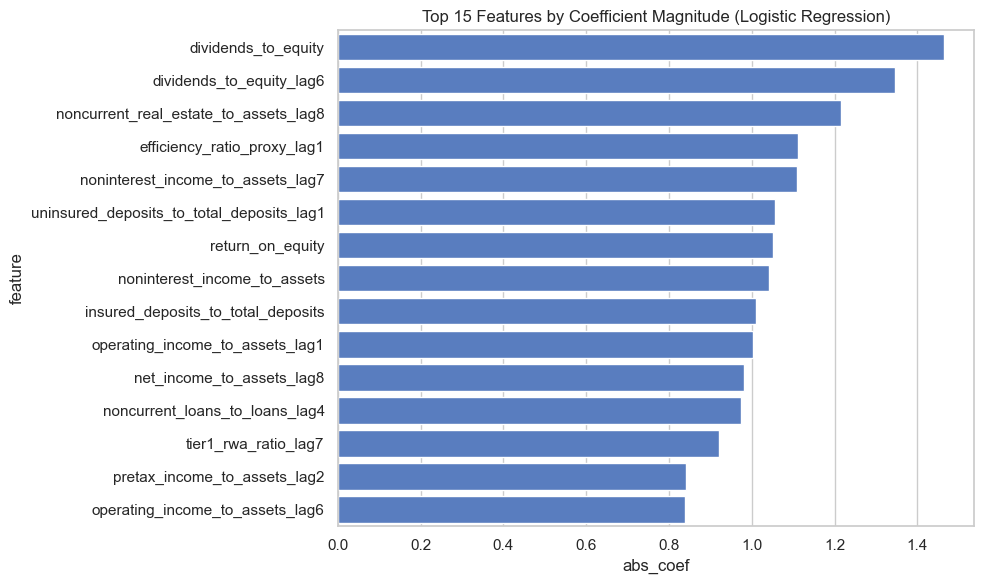

In [449]:
coefs = lr_model.coef_[0]
importance_df_lr = pd.DataFrame({
    'feature': features,
    'coefficient': coefs,
    'abs_coef': np.abs(coefs)
}).sort_values(by='abs_coef', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_lr.head(15), x='abs_coef', y='feature')
plt.title('Top 15 Features by Coefficient Magnitude (Logistic Regression)')
plt.tight_layout()
plt.show()

In [450]:
importance_df_lr.head(15)

feature  coefficient  abs_coef
3                          dividends_to_equity    -1.463574  1.463574
130                   dividends_to_equity_lag6     1.346005  1.346005
177      noncurrent_real_estate_to_assets_lag8     1.214981  1.214981
32                 efficiency_ratio_proxy_lag1     1.111966  1.111966
159          noninterest_income_to_assets_lag7    -1.109790  1.109790
42   uninsured_deposits_to_total_deposits_lag1     1.055208  1.055208
16                            return_on_equity    -1.050610  1.050610
11                noninterest_income_to_assets    -1.041643  1.041643
21          insured_deposits_to_total_deposits    -1.010573  1.010573
34             operating_income_to_assets_lag1     1.003045  1.003045
186                  net_income_to_assets_lag8     0.981140  0.981140
90              noncurrent_loans_to_loans_lag4     0.973710  0.973710
149                       tier1_rwa_ratio_lag7     0.921620  0.921620
61                pretax_income_to_assets_lag2     0.839804  0.839804
139            operating_income_to_assets_lag6     0.837382  0.837382

Results are bad , lets resample out minority class by using SMOTE technique

In [311]:
from imblearn.over_sampling import SMOTE

In [313]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply on scaled features
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [314]:
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(4404), np.int64(1): np.int64(4404)}


In [315]:
# Predict probabilities
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
lr_preds = lr_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)

In [316]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

results_after_smote = {
    'Logistic Regression (SMOTE)': {
        'ROC AUC': roc_auc_score(y_test, lr_probs),
        'Confusion Matrix': confusion_matrix(y_test, lr_preds),
        'Classification Report': classification_report(y_test, lr_preds, output_dict=True)
    },
    'Random Forest (SMOTE)': {
        'ROC AUC': roc_auc_score(y_test, rf_probs),
        'Confusion Matrix': confusion_matrix(y_test, rf_preds),
        'Classification Report': classification_report(y_test, rf_preds, output_dict=True)
    },
    'XGBoost (SMOTE)': {
        'ROC AUC': roc_auc_score(y_test, xgb_probs),
        'Confusion Matrix': confusion_matrix(y_test, xgb_preds),
        'Classification Report': classification_report(y_test, xgb_preds, output_dict=True)
    }
}

c:\Users\khali\OneDrive\Documents\GitHub\financial_crisis_failure_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Documents\GitHub\financial_crisis_failure_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\OneDrive\Documents\GitHub\financial_crisis_failure_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

In [317]:
for model_name, metrics in results_after_smote.items():
    print(f"\n=== {model_name} ===")
    print(f"ROC AUC: {metrics['ROC AUC']:.3f}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("Classification Report:")
    print(classification_report(y_test, 
                                lr_preds if "Logistic" in model_name else 
                                rf_preds if "Random" in model_name else 
                                xgb_preds,
                                zero_division=0))


=== Logistic Regression (SMOTE) ===
ROC AUC: 0.698
Confusion Matrix:
[[1565  323]
 [  47   31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1888
           1       0.09      0.40      0.14        78

    accuracy                           0.81      1966
   macro avg       0.53      0.61      0.52      1966
weighted avg       0.94      0.81      0.86      1966


=== Random Forest (SMOTE) ===
ROC AUC: 0.746
Confusion Matrix:
[[1888    0]
 [  78    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1888
           1       0.00      0.00      0.00        78

    accuracy                           0.96      1966
   macro avg       0.48      0.50      0.49      1966
weighted avg       0.92      0.96      0.94      1966


=== XGBoost (SMOTE) ===
ROC AUC: 0.766
Confusion Matrix:
[[1877   11]
 [  74    4]]
Classification Report:
    

In [318]:
from sklearn.metrics import precision_recall_curve

probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Choose a threshold with higher recall (e.g., 0.2)
custom_preds = (probs >= 0.2).astype(int)

In [319]:
print(confusion_matrix(y_test, custom_preds))
print(classification_report(y_test, custom_preds))

[[1847   41]
 [  69    9]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1888
           1       0.18      0.12      0.14        78

    accuracy                           0.94      1966
   macro avg       0.57      0.55      0.56      1966
weighted avg       0.93      0.94      0.94      1966



In [320]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Feature selector based on feature importance
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')

# Fit on the resampled training data
selector.fit(X_train_resampled, y_train_resampled)

# Transform train and test data
X_train_sel = selector.transform(X_train_resampled)
X_test_sel = selector.transform(X_test_scaled)

In [321]:
print("Selected features:", X_train_sel.shape[1], "out of", X_train_resampled.shape[1])

Selected features: 95 out of 190


In [322]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Define base models
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', scale_pos_weight=(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum(), random_state=42)

# Combine in a soft voting ensemble
voting_model = VotingClassifier(
    estimators=[('lr', lr), ('xgb', xgb)],
    voting='soft'
)

# Fit ensemble on reduced training set
voting_model.fit(X_train_sel, y_train_resampled)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            fea...,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [323]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Predict
voting_probs = voting_model.predict_proba(X_test_sel)[:, 1]
voting_preds = voting_model.predict(X_test_sel)

# Evaluate
print("=== Voting Ensemble ===")
print(f"ROC AUC: {roc_auc_score(y_test, voting_probs):.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, voting_preds))
print("Classification Report:")
print(classification_report(y_test, voting_preds, zero_division=0))


=== Voting Ensemble ===
ROC AUC: 0.754
Confusion Matrix:
[[1803   85]
 [  64   14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1888
           1       0.14      0.18      0.16        78

    accuracy                           0.92      1966
   macro avg       0.55      0.57      0.56      1966
weighted avg       0.93      0.92      0.93      1966

